<a href="https://colab.research.google.com/github/clachevv/neuro-match-project/blob/main/notebooks/fmri_loaded_from_memory.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
#@title Installations
%%capture

!pip install nilearn
!pip install decord

In [29]:
#@title Imports
import glob
import numpy as np
import urllib
import torch
import cv2
import argparse
import time
import random
import seaborn as sns
import matplotlib.pyplot as plt
import nibabel as nib
import pickle
import pandas as pd
# from nilearn import plotting
from tqdm import tqdm
from torchvision import transforms as trn
import os
from PIL import Image
from nilearn import datasets
from nilearn import surface
from decord import VideoReader
from decord import cpu
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA, IncrementalPCA

In [3]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [4]:
#@title Utility functions for data loading
def save_dict(di_, filename_):
    with open(filename_, 'wb') as f:
        pickle.dump(di_, f)

def load_dict(filename_):
    with open(filename_, 'rb') as f:
        u = pickle._Unpickler(f)
        u.encoding = 'latin1'
        ret_di = u.load()
    return ret_di

def visualize_activity(vid_id,sub):
  fmri_dir = './participants_data_v2021'
  track = "full_track"
  results_dir = '/content/'
  track_dir = os.path.join(fmri_dir, track)
  sub_fmri_dir = os.path.join(track_dir, sub)
  fmri_train_all,voxel_mask = get_fmri(sub_fmri_dir,"WB")
  visual_mask_3D = np.zeros((78,93,71))
  visual_mask_3D[voxel_mask==1]= fmri_train_all[vid_id,:]
  brain_mask = '/content/example.nii'
  nii_save_path =  os.path.join(results_dir, 'vid_activity.nii')
  saveasnii(brain_mask,nii_save_path,visual_mask_3D)
  plotting.plot_glass_brain(nii_save_path,
                          title='fMRI response',plot_abs=False,
                          display_mode='lyr',colorbar=True)

def get_fmri(fmri_dir, ROI):
    """This function loads fMRI data into a numpy array for to a given ROI.
    Parameters
    ----------
    fmri_dir : str
        path to fMRI data.
    ROI : str
        name of ROI.
    Returns
    -------
    np.array
        matrix of dimensions #train_vids x #repetitions x #voxels
        containing fMRI responses to train videos of a given ROI
    """


    # Loading ROI data
    ROI_file = os.path.join(fmri_dir, ROI + ".pkl")
    ROI_data = load_dict(ROI_file)

    # averaging ROI data across repetitions
    ROI_data_train = np.mean(ROI_data["train"], axis = 1)
    if ROI == "WB":
        voxel_mask = ROI_data['voxel_mask']
        return ROI_data_train, voxel_mask

    return ROI_data_train

def saveasnii(brain_mask,nii_save_path,nii_data):
    img = nib.load(brain_mask)
    nii_img = nib.Nifti1Image(nii_data, img.affine, img.header)
    nib.save(nii_img, nii_save_path)

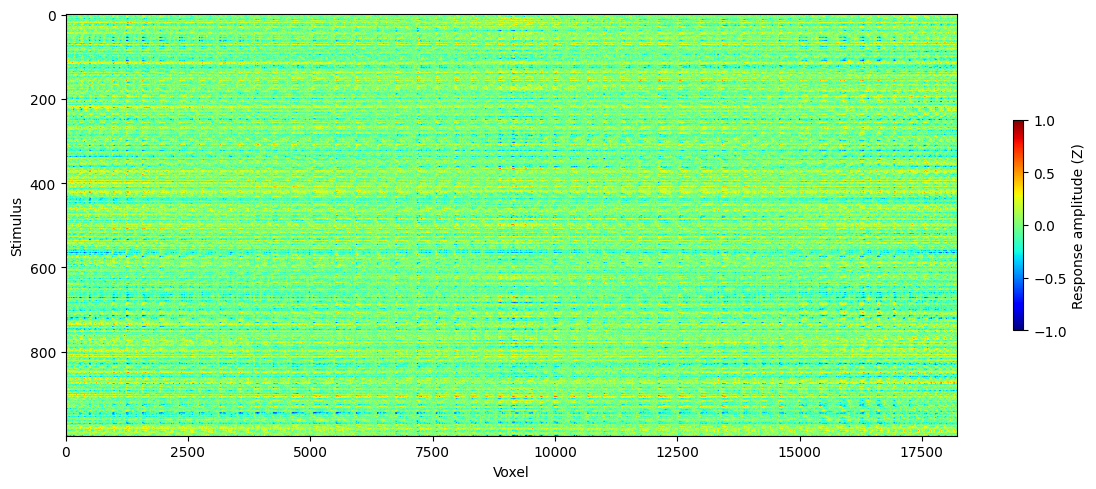

In [5]:
#@title Loading fMRI data and inspecting dimensions
sub = 'sub01'  #@param ["sub01","sub02","sub03","sub04","sub05","sub06","sub07","sub08","sub09","sub10"]

ROI = 'WB'  #@param ["WB", "V1", "V2","V3", "V4", "LOC", "EBA", "FFA","STS", "PPA"]

######## fMRI data loader wrapper code ###################################
fmri_dir = '/content/drive/MyDrive/neuromatch/participants_data_v2021'
if ROI == "WB":
    track = "full_track"
else:
    track = "mini_track"
results_dir = '/content/'
track_dir = os.path.join(fmri_dir, track)
sub_fmri_dir = os.path.join(track_dir, sub)
if track == "full_track":
    fmri_train_all,voxel_mask = get_fmri(sub_fmri_dir,ROI)
else:
    fmri_train_all = get_fmri(sub_fmri_dir,ROI)

######## fMRI data loader wrapper code ###################################


f, ax = plt.subplots(figsize=(12, 5))
ax.set(xlabel="Voxel", ylabel="Stimulus")
heatmap = ax.imshow(fmri_train_all, aspect="auto",cmap='jet',vmin=-1,vmax=1)
f.colorbar(heatmap, shrink=.5, label="Response amplitude (Z)")
f.tight_layout()

fMRI_RDMs is a dictionary with keys `'EVC_RDMs'` and `'IT_RDMs'` corresponding to ROIs EVC and IT respectively. The shape of each RDM is `num_subjects` $\times$ `num_stimulus` $\times$ `num_stimulus`.

- dict - 9 ROIs
- dict[ROI] = 10 x 1000 x 1000

In [6]:
subjects = ["sub01","sub02","sub03","sub04","sub05","sub06","sub07","sub08","sub09","sub10"]
ROIs = ["V1", "V2","V3", "V4", "LOC", "EBA", "FFA","STS", "PPA"]
fmri_dir = '/content/drive/MyDrive/neuromatch/participants_data_v2021'
track_dir = os.path.join(fmri_dir, "mini_track")

fmri_results = {}
for sub in subjects:
  all_brain_scan = {}
  for ROI in ROIs:
    sub_fmri_dir = os.path.join(track_dir, sub)
    all_brain_scan[ROI]=get_fmri(sub_fmri_dir, ROI)
  fmri_results[sub]=all_brain_scan

# fmri_results = {}
# all_brain_scan = {"WB":fmri_train_all}
# fmri_results["sub01"] = all_brain_scan

In [7]:
# this loads result from AlexNet Classification (with LLM reduction)
classes = pd.read_csv('/content/drive/MyDrive/neuromatch/video categories.csv', header=0)
classes['video_path'] = classes['video_id']
classes['video_id'] = classes['video_id'].str.split("/").str.get(3)
classes = classes[classes['index'] <= 1000]
classes['act_index'] = classes['index'] + 1
dicty = classes[['act_index',' llm_classes']]

In [8]:
filtered_activity = {}
for sub, ROIs in fmri_results.items():
    for ROI,data in ROIs.items():
        brain = pd.DataFrame(data).reset_index()
        brain['index'] = brain['index']+1
        brain.columns = ['act_' + str(item) for item in brain.columns]
        filtered_brain = brain.merge(dicty, on = 'act_index', how='right')
        filtered_activity[f'{sub}_{ROI}'] = filtered_brain

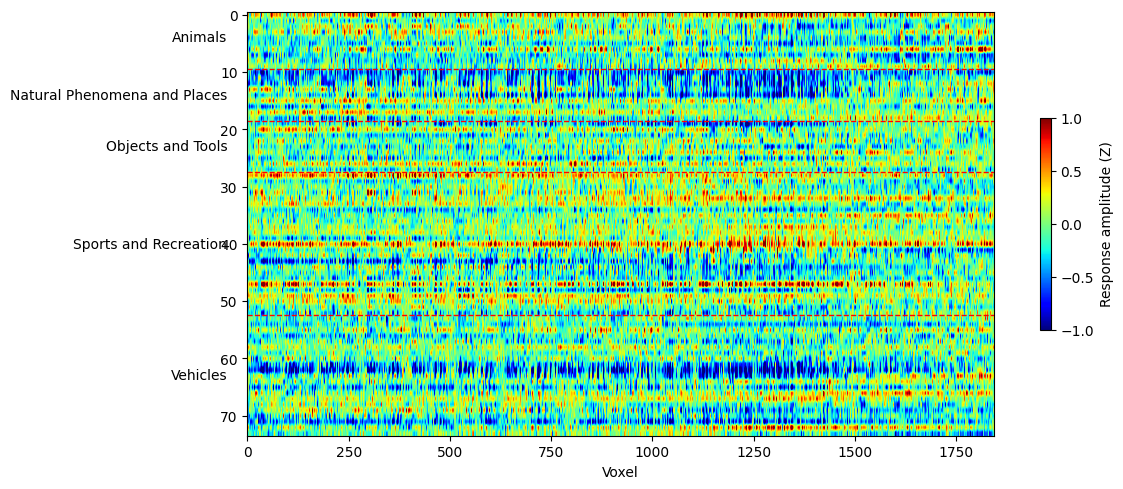

In [9]:
f, ax = plt.subplots(figsize=(12, 5))

# Calculate class boundaries for annotation

maping_video_classes = dict(zip(dicty.index, dicty[' llm_classes']))
stimuli_classes = list(maping_video_classes.values())

unique_classes = list(pd.unique(stimuli_classes))
class_indices = {cls: [] for cls in unique_classes}
for idx, cls in enumerate(stimuli_classes):
    class_indices[cls].append(idx)

ax.set(xlabel="Voxel", ylabel="Stimulus")
plot_array = filtered_activity['sub01_LOC'].drop(columns=['act_index',' llm_classes']).to_numpy()
heatmap = ax.imshow(plot_array, aspect="auto",cmap='jet',vmin=-1,vmax=1)

end_indices = [indices[-1] + 0.5 for indices in class_indices.values()]
for end in end_indices[:-1]:
    plt.axhline(y=end, color='red', linestyle='--', linewidth=1)

for cls, indices in class_indices.items():
    middle = int(np.mean(indices))
    ax.text(-50, middle, cls, fontsize=10, color='black', rotation=0,
                verticalalignment='center', horizontalalignment='right')


plt.ylabel('')
f.colorbar(heatmap, shrink=.5, label="Response amplitude (Z)")
f.tight_layout()


In [10]:
model_RDMs = {}

for sub_roi, fmri in filtered_activity.items():
    plot_array = fmri.drop(columns=['act_index',' llm_classes']).to_numpy()
    model_RDMs[sub_roi] = 1- np.corrcoef(plot_array)

In [11]:
final_df = pd.DataFrame()
for sub_ROI, weights in model_RDMs.items():
    df = pd.DataFrame(weights)
    df.columns = ["video_"+str(col) for col in df.columns]
    df['sub_ROI'] = sub_ROI
    df = df.reset_index()
    df['index'] =  "video_" + df['index'].astype(str)
    final_df = pd.concat([final_df,df])

final_df.to_csv("/content/drive/MyDrive/neuromatch/results/rdm_values_fmri.csv",index=False)

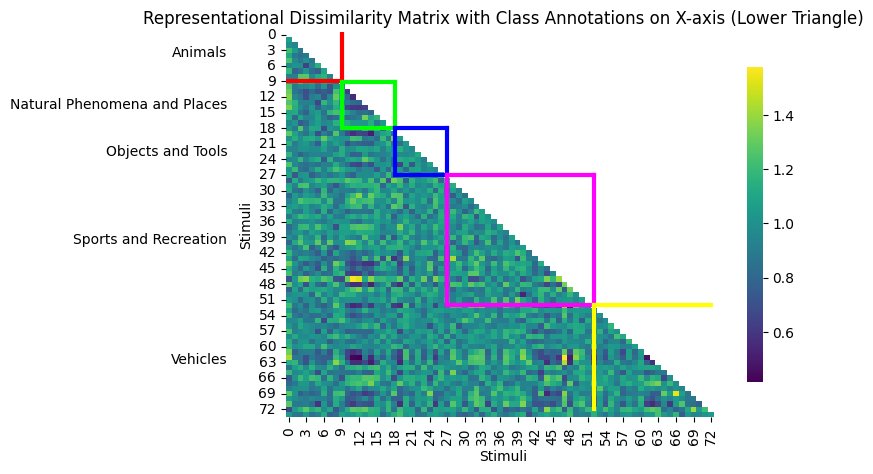

In [13]:
stimuli_classes = list(maping_video_classes.values())
rdm = model_RDMs['sub01_LOC']
mask = np.triu(np.ones_like(rdm, dtype=bool))

# Create the heatmap
f, ax = plt.subplots(figsize=(7, 5))

sns.heatmap(rdm, mask=mask, cmap='viridis', square=False, cbar_kws={"shrink": .82},ax=ax)

# Calculate class boundaries for annotation
unique_classes = list(pd.unique(stimuli_classes))
class_indices = {cls: [] for cls in unique_classes}
for idx, cls in enumerate(stimuli_classes):
    class_indices[cls].append(idx)

for cls, indices in class_indices.items():
    middle = int(np.mean(indices))
    ax.text(-10, middle, cls, fontsize=10, color='black', rotation=0,
                verticalalignment='center', horizontalalignment='right')


plt.plot([9.5, 9.5], [9.5, 0], color=[1, 0, 0], linestyle='-', linewidth=3)     # animal
plt.plot([9.5, 0], [9.5, 9.5], color=[1, 0, 0], linestyle='-', linewidth=3)     # animal

plt.plot([9.55, 9.55], [18.55, 9.55], color=[0, 1, 0], linestyle='-', linewidth=3)     # natural phenomena and places
plt.plot([18.55, 9.55], [9.55, 9.55], color=[0, 1, 0], linestyle='-', linewidth=3)     # natural phenomena and places
plt.plot([9.55, 18.55], [18.55, 18.55], color=[0, 1, 0], linestyle='-', linewidth=3)     # natural phenomena and places
plt.plot([18.55, 18.55], [9.55, 18.55], color=[0, 1, 0], linestyle='-', linewidth=3)     # natural phenomena and places

plt.plot([18.55, 18.55], [27.55, 18.55], color=[0, 0, 1], linestyle='-', linewidth=3)     # object and tools
plt.plot([27.55, 18.55], [18.55, 18.55], color=[0, 0, 1], linestyle='-', linewidth=3)     # object and tools
plt.plot([18.55, 27.55], [27.55, 27.55], color=[0, 0, 1], linestyle='-', linewidth=3)     # object and tools
plt.plot([27.55, 27.55], [18.55, 27.55], color=[0, 0, 1], linestyle='-', linewidth=3)     # object and tools

plt.plot([27.55, 27.55], [52.55, 27.55], color=[1, 0, 1], linestyle='-', linewidth=3)     # sports and recreation
plt.plot([52.55, 27.55], [27.55, 27.55], color=[1, 0, 1], linestyle='-', linewidth=3)     # sports and recreation
plt.plot([27.55, 52.55], [52.55, 52.55], color=[1, 0, 1], linestyle='-', linewidth=3)     # sports and recreation
plt.plot([52.55, 52.55], [27.55, 52.55], color=[1, 0, 1], linestyle='-', linewidth=3)     # sports and recreation

plt.plot([52.55, 52.55], [72.55, 52.55], color=[1, 1, 0], linestyle='-', linewidth=3)     # vehicles
plt.plot([72.55, 52.55], [52.55, 52.55], color=[1, 1, 0], linestyle='-', linewidth=3)     # vehicles

plt.xlabel('Stimuli')
plt.ylabel('Stimuli')
plt.title('Representational Dissimilarity Matrix with Class Annotations on X-axis (Lower Triangle)')
plt.show()

In [40]:
filtered_activity['sub01_LOC'].drop(columns=['act_index',' llm_classes']).T.to_csv("fmri.csv",index=False)

In [87]:
sub_loc = [key for key in filtered_activity.keys() if "LOC" in key]
n_components = 100
seed=42

train_out, test_out = {},{}
for sub in sub_loc[:1]:#tqdm(sub_loc):
    data = filtered_activity['sub01_LOC']
    numpyarray = data.drop(columns=['act_index',' llm_classes']).to_numpy()
    x_train = numpyarray[:70,:]
    x_test = numpyarray[4:,:]


    start_time = time.time()
    x_test = StandardScaler().fit_transform(x_test)
    x_train = StandardScaler().fit_transform(x_train)
    ipca = PCA(random_state=seed, n_components=48)
    ipca.fit(x_train)

    explained_variance = ipca.explained_variance_ratio_
    cumulative_explained_variance = explained_variance.cumsum()

    train = ipca.transform(x_train)
    test = ipca.transform(x_test)
    train_out[sub]=train
    test_out[sub]=test

114.0